#DIABETIC RETINOPATHY DETECTION:

Task: classify retina images in 5 possible given states.

DATASET USED: https://www.kaggle.com/datasets/sachinkumar413/diabetic-retinopathy-dataset

#Import libs

In [2]:
import os 
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-633c4926-f4bd-2fc3-a3c9-ef4365c17e18)


#DATA LOAD AND PREPARATIONS

In [3]:
TRAIN_PATH = "/content/drive/MyDrive/MDA_PORTFOLIO/Project 3 Diabetic Retinopathy Detection/train"

os.listdir(path=TRAIN_PATH) # classification targets 

['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']

INSPECT DATA:

  - Images for each class
  - Inspect images 

Total number of train images = 2750


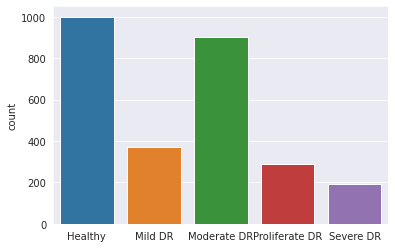

In [4]:
train = []
label = []

#each folder represents a target for the image classification:


for target in os.listdir(path=TRAIN_PATH):
  train_class = os.listdir(os.path.join(TRAIN_PATH, target)) # folder with one of the target images 
  for image in train_class:
    img = os.path.join(TRAIN_PATH,target,image) # individual image inside target folder
    train.append(img)
    label.append(target)

print("Total number of train images = {}".format(len(train)))

sns.set_style('darkgrid')
sns.countplot(x = label)

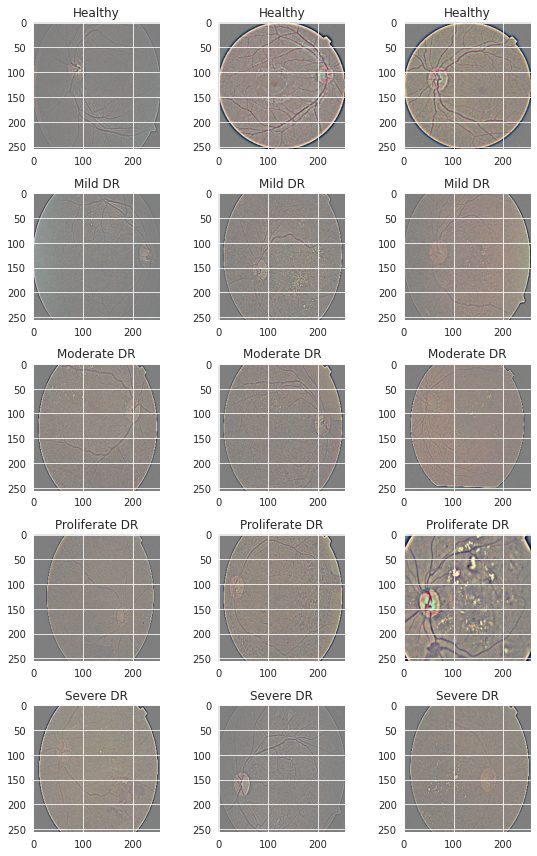

In [48]:
#plot grid configuration
ROWS = 5
COLS = 3

fig, axs = plt.subplots(nrows= ROWS,ncols= COLS,figsize=(8,12))
#ax number initialization
count = 0
for target in os.listdir(TRAIN_PATH):
  train_class = os.listdir(os.path.join(TRAIN_PATH,target))
  for e in range(COLS):
    img = os.path.join(TRAIN_PATH,target,train_class[e])
    img = PIL.Image.open(img)
    axs[count][e].title.set_text(target)
    axs[count][e].imshow(img)
  count += 1
fig.tight_layout()

#Image DataFrame Creation

  DataFrame with all training images paths and corresponding label 

In [6]:
image_df = pd.DataFrame({'Image':train, 'Label': label})
image_df

,Image,Label
0,/content/drive/MyDrive/MDA_PORTFOLIO/Project 3...,Healthy
1,/content/drive/MyDrive/MDA_PORTFOLIO/Project 3...,Healthy
2,/content/drive/MyDrive/MDA_PORTFOLIO/Project 3...,Healthy
3,/content/drive/MyDrive/MDA_PORTFOLIO/Project 3...,Healthy
4,/content/drive/MyDrive/MDA_PORTFOLIO/Project 3...,Healthy
...,...,...
2745,/content/drive/MyDrive/MDA_PORTFOLIO/Project 3...,Severe DR
2746,/content/drive/MyDrive/MDA_PORTFOLIO/Project 3...,Severe DR
2747,/content/drive/MyDrive/MDA_PORTFOLIO/Project 3...,Severe DR
2748,/content/drive/MyDrive/MDA_PORTFOLIO/Project 3...,Severe DR


In [7]:
image_df['Label'].value_counts()

Healthy           1000
Moderate DR        900
Mild DR            370
Proliferate DR     290
Severe DR          190
Name: Label, dtype: int64

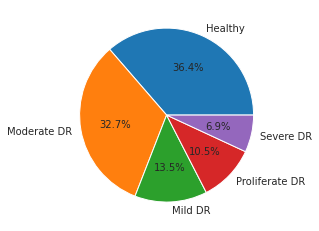

In [8]:
plt.pie(x=image_df['Label'].value_counts(),
        labels = image_df['Label'].value_counts().index,
        autopct='%1.1f%%')
plt.show()


#Split dataset into training, validation and test 

In [49]:
image_df_shuffled = shuffle(image_df, random_state=42)

train, test = train_test_split(image_df_shuffled, test_size = 0.10,random_state=40)

print('Train images = {}'.format(train.shape[0]))
print('Number images each class in train dataset \n______\n')
print(train['Label'].value_counts())
print('\n\n')
print('Test images = {}'.format(test.shape[0]))
print('Number images each class in test dataset \n______\n')
print(test['Label'].value_counts())


Train images = 2475
Number images each class in train dataset 
______

Healthy           905
Moderate DR       805
Mild DR           339
Proliferate DR    258
Severe DR         168
Name: Label, dtype: int64



Test images = 275
Number images each class in test dataset 
______

Healthy           95
Moderate DR       95
Proliferate DR    32
Mild DR           31
Severe DR         22
Name: Label, dtype: int64


#DATA AUGMENTATION

###Create train and test data generators


In [50]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rescale = 1./255,
    #shear_range = 0.05,
    validation_split = 0.2,
    horizontal_flip = True,
    #vertical_flip = True,
    #rotation_range = 5
    #fill_mode ='nearest'
    )

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rescale= 1./255)


In [51]:
train_data = train_datagen.flow_from_dataframe(
    train,
    directory= './',
    x_col = 'Image',
    y_col = 'Label',
    target_size = (224,224), # resizes all found images to specified dimensions (same as Input for VGG19)
    color_mode = 'rgb',
    #classes = classes,
    class_mode = 'categorical',
    batch_size = 36,
    subset = 'training',
    shuffle = False)

validation_data = train_datagen.flow_from_dataframe(
    train,
    directory= './',
    x_col = 'Image',
    y_col = 'Label',
    target_size = (224,224), # resizes all found images to specified dimensions
    color_mode = 'rgb',
    #classes = classes,
    class_mode = 'categorical',
    batch_size = 11,
    subset = 'validation',
    shuffle = False
)

test_data =  test_datagen.flow_from_dataframe(
    test,
    directory= './',
    x_col = 'Image',
    y_col = 'Label',
    target_size = (224,224), # resizes all found images to specified dimensions
    color_mode = 'rgb',
    class_mode = 'categorical',
    #classes = classes,
    batch_size = 55,
)

Found 1980 validated image filenames belonging to 5 classes.
Found 495 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


#Transfer learning approach



Loading VGG19 model

Replace top layers with custom layers allowing 5 class classification.











In [52]:
# VGG19 model and summary
input_tensor = tf.keras.layers.Input(shape=(224,224,3))
resnet = tf.keras.applications.vgg19.VGG19(include_top=True,weights='imagenet', input_tensor=input_tensor)

resnet.trainable = False # later we feeze near all layers
resnet.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

##FINE TUNNING VGG19

In [61]:
for layer in resnet.layers[:]:
  layer.trainable = True

x = resnet.layers[-3].output # InceptionV3 without last Dense layer that has 1000 classes
#x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.Dense(units=512,activation='sigmoid')(x)
x = tf.keras.layers.Dropout(rate=0.1)(x)
x = tf.keras.layers.Dense(units=4096, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.1)(x)
x = tf.keras.layers.Dense(units=1024, activation='sigmoid')(x)
x = tf.keras.layers.Dropout(rate=0.1)(x)
x = tf.keras.layers.Dense(units=512, activation='sigmoid')(x)
x = tf.keras.layers.Dropout(rate=0.1)(x)
x = tf.keras.layers.Dense(units=256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(units=128, activation='sigmoid')(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
output = tf.keras.layers.Dense(units=5, activation='softmax')(x)

model = tf.keras.Model(inputs = resnet.input, outputs = output)



model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Compile and fit the model

In [62]:
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
metrics = ["accuracy"]

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 10, # Stops when loss does not improve in 10 epochs
    verbose=1,
    mode='min',)

checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/MDA_PORTFOLIO/Project 3 Diabetic Retinopathy Detection/weights/vgg19_weights.hdf5',verbose=1, save_best_only=True)

model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = metrics)

#model.load_weights('/content/xCeption.hdf5')

#Healthy': 0,'Mild DR': 1,'Moderate DR': 2,'Proliferate DR': 3,'Severe DR': 4
class_weight = {0: 0.05,1: 0.5,2: 0.05,3: 0.2,4: 0.2}



epochs = 50

history= model.fit(train_data, 
          batch_size =54 ,
          epochs = epochs,
          validation_data = validation_data,
          validation_steps = 11,
          #class_weight=class_weight,
          callbacks = [early_stopping,checkpoint],
          )

Epoch 1/50
55/55 [==============================] - ETA: 0s - loss: 1.1935 - accuracy: 0.5758
Epoch 1: val_loss improved from inf to 1.23556, saving model to /content/drive/MyDrive/MDA_PORTFOLIO/Project 3 Diabetic Retinopathy Detection/weights/vgg19_weights.hdf5
55/55 [==============================] - 49s 867ms/step - loss: 1.1935 - accuracy: 0.5758 - val_loss: 1.2356 - val_accuracy: 0.6281
Epoch 2/50
55/55 [==============================] - ETA: 0s - loss: 0.9028 - accuracy: 0.7591
Epoch 2: val_loss improved from 1.23556 to 1.03450, saving model to /content/drive/MyDrive/MDA_PORTFOLIO/Project 3 Diabetic Retinopathy Detection/weights/vgg19_weights.hdf5
55/55 [==============================] - 49s 880ms/step - loss: 0.9028 - accuracy: 0.7591 - val_loss: 1.0345 - val_accuracy: 0.7273
Epoch 3/50
55/55 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.7874
Epoch 3: val_loss improved from 1.03450 to 0.87238, saving model to /content/drive/MyDrive/MDA_PORTFOLIO/Project

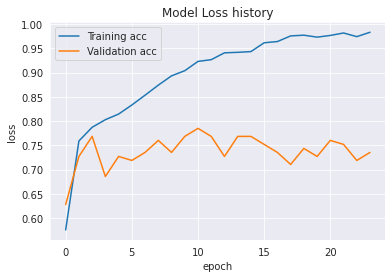

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss history')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training acc','Validation acc'])
plt.show()


#MODEL PERFORMANCE

In [65]:
model.load_weights('/content/drive/MyDrive/MDA_PORTFOLIO/Project 3 Diabetic Retinopathy Detection/weights/vgg19_weights.hdf5')

evaluate = model.evaluate(test_data, batch_size= test_data.n//5,verbose=1 ,)

print('Accuracy Test = {}'.format(evaluate[1]))

5/5 [==============================] - 2s 325ms/step - loss: 0.8115 - accuracy: 0.7200
Accuracy Test = 0.7200000286102295


In [66]:
test_labels = test_data.classes

predictions = model.predict(x=test_data, verbose=1)

5/5 [==============================] - 2s 339ms/step


#CONFUSION MATRIX

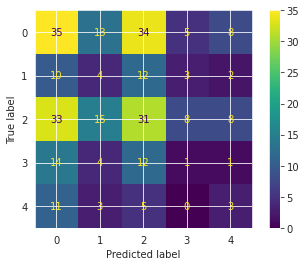

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true=test_labels, y_pred= predictions.argmax(axis=1))

cm_plot_labels=[]
for item in test_data.class_indices.values():
  cm_plot_labels.append(str(item))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=cm_plot_labels)
disp.plot()
plt.show()

In [68]:
test_data.class_indices

{'Healthy': 0,
 'Mild DR': 1,
 'Moderate DR': 2,
 'Proliferate DR': 3,
 'Severe DR': 4}

In [69]:
class_report = classification_report(y_true = test_labels, y_pred=predictions.argmax(axis=1), target_names=cm_plot_labels, digits=2)
print(class_report)

              precision    recall  f1-score   support

           0       0.34      0.37      0.35        95
           1       0.10      0.13      0.11        31
           2       0.33      0.33      0.33        95
           3       0.06      0.03      0.04        32
           4       0.14      0.14      0.14        22

    accuracy                           0.27       275
   macro avg       0.19      0.20      0.19       275
weighted avg       0.26      0.27      0.26       275

